 # UDACITY Capstone project : "Shelter Animal Outcomes"

The data for this project has been obtained from a Kaggle competition:

https://www.kaggle.com/c/shelter-animal-outcomes/data .

My goal is to predict the outcome of the animal as they leave the Animal Center...

## Data Description

As described on Kaggle:

*Every year, approximately 7.6 million companion animals end up in US shelters. Many animals are given up as unwanted by their owners, while others are picked up after getting lost or taken out of cruelty situations. Many of these animals find forever families to take them home, but just as many are not so lucky. 2.7 million dogs and cats are euthanized in the US every year.*

We use the date comes from Austin Animal Center (October 1st, 2013 - March, 2016). Outcomes represent the status of animals as they leave the Animal Center. 

Let's first import the necessary modules...

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import log_loss
import seaborn as sns
%matplotlib inline

Let's have a first look at the data:

In [3]:
data = pd.read_csv("train.csv", parse_dates=['DateTime'])
print "The shelter data has %d examples and has %d attributes" %(data.shape[0],data.shape[1])
data.head()

The shelter data has 26729 examples and has 10 attributes


AnimalID     Name            DateTime      OutcomeType OutcomeSubtype  \
0  A671945  Hambone 2014-02-12 18:22:00  Return_to_owner            NaN   
1  A656520    Emily 2013-10-13 12:44:00       Euthanasia      Suffering   
2  A686464   Pearce 2015-01-31 12:28:00         Adoption         Foster   
3  A683430      NaN 2014-07-11 19:09:00         Transfer        Partner   
4  A667013      NaN 2013-11-15 12:52:00         Transfer        Partner   

  AnimalType SexuponOutcome AgeuponOutcome                        Breed  \
0        Dog  Neutered Male         1 year        Shetland Sheepdog Mix   
1        Cat  Spayed Female         1 year       Domestic Shorthair Mix   
2        Dog  Neutered Male        2 years                 Pit Bull Mix   
3        Cat    Intact Male        3 weeks       Domestic Shorthair Mix   
4        Dog  Neutered Male        2 years  Lhasa Apso/Miniature Poodle   

         Color  
0  Brown/White  
1  Cream Tabby  
2   Blue/White  
3   Blue Cream  
4          Tan

In [4]:
data.describe()

AnimalID   Name             DateTime OutcomeType OutcomeSubtype  \
count     26729  19038                26729       26729          13117   
unique    26729   6374                22918           5             16   
top     A705677    Max  2015-08-11 00:00:00    Adoption        Partner   
freq          1    136                   19       10769           7816   
first       NaN    NaN  2013-10-01 09:31:00         NaN            NaN   
last        NaN    NaN  2016-02-21 19:17:00         NaN            NaN   

       AnimalType SexuponOutcome AgeuponOutcome                   Breed  \
count       26729          26728          26711                   26729   
unique          2              5             44                    1380   
top           Dog  Neutered Male         1 year  Domestic Shorthair Mix   
freq        15595           9779           3969                    8810   
first         NaN            NaN            NaN                     NaN   
last          NaN            NaN            NaN                     NaN   

              Color  
count         26729  
unique          366  
top     Black/White  
freq           2824  
first           NaN  
last            NaN

In [5]:
test_data = pd.read_csv("test.csv", parse_dates=['DateTime'])
test_data.head()

ID      Name            DateTime AnimalType SexuponOutcome AgeuponOutcome  \
0   1    Summer 2015-10-12 12:15:00        Dog  Intact Female      10 months   
1   2  Cheyenne 2014-07-26 17:59:00        Dog  Spayed Female        2 years   
2   3       Gus 2016-01-13 12:20:00        Cat  Neutered Male         1 year   
3   4     Pongo 2013-12-28 18:12:00        Dog    Intact Male       4 months   
4   5   Skooter 2015-09-24 17:59:00        Dog  Neutered Male        2 years   

                            Breed        Color  
0          Labrador Retriever Mix    Red/White  
1  German Shepherd/Siberian Husky    Black/Tan  
2          Domestic Shorthair Mix  Brown Tabby  
3               Collie Smooth Mix     Tricolor  
4            Miniature Poodle Mix        White

We would like to know whether any data is missing or not!

In [6]:
print "\nMissing Numbers in Training Set?\n"
print data.isnull().sum()
print "\nMissing Numbers in Testing Set?\n"
print test_data.isnull().sum()
data['SexuponOutcome'] =data['SexuponOutcome'].fillna("Neutered Male")
data['AgeuponOutcome'] =data['AgeuponOutcome'].fillna("1 year")


Missing Numbers in Training Set?

AnimalID              0
Name               7691
DateTime              0
OutcomeType           0
OutcomeSubtype    13612
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       18
Breed                 0
Color                 0
dtype: int64

Missing Numbers in Testing Set?

ID                   0
Name              3225
DateTime             0
AnimalType           0
SexuponOutcome       0
AgeuponOutcome       6
Breed                0
Color                0
dtype: int64


We can see that many of the animals have missing names. Although, names don't matter as such, however later we will show that whether the animal is named has an effect on its outcome. The many missing OutcomeSubtype values should also not matter since we are only trying to predict the OutcomeType. For missing values for AgeuponOutcome, I am replacing that with the most frequenct value "1 year". For now, we do not need AnimalId, Color, DateTime, and OutcomeSubtype.

In [7]:
del data["AnimalID"]
del data["DateTime"]
del data["OutcomeSubtype"]

We have 5 different outcomes. Let's plot the distributions of outcomes

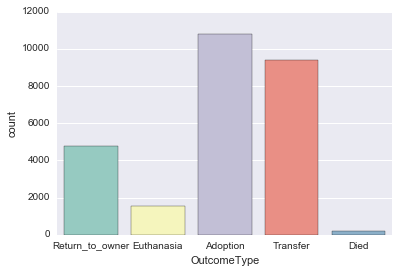

In [8]:
import seaborn as sns
%matplotlib inline
sns.countplot(data.OutcomeType, palette='Set3')

Now let's plot the outcomes by sex

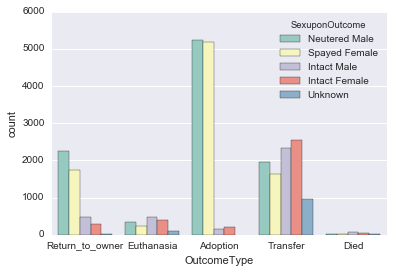

In [9]:
sns.countplot(data=data, x='OutcomeType',hue='SexuponOutcome', palette="Set3")

Thus plot gives us some interesting information:
Neutered Male and Spayed Female have a great chance to be adopted, and a pretty decent chance to be returned to the owner. However, it appears harder to find new family for Intact Male and Intact Female! 

The next observation is that we do not know some animals' names. I think, animals with known name should be more likely to return home since we can suggest that these animals has an ID tag. Thus, can replace known name by 1 and unknown name by 0. We also should replace strings in "AnimalType" by numeric values e.g. 'dog':1, 'cat':0

In [10]:
data['Name'] =data['Name'].fillna(0)
data.loc[data['Name'] != 0, "Name"] = 1

print(data["AnimalType"].unique())
data.loc[data["AnimalType"]== "Dog", "AnimalType"] = 1
data.loc[data["AnimalType"]!= 1, "AnimalType"] = 0
data.head()

['Dog' 'Cat']


Name      OutcomeType AnimalType SexuponOutcome AgeuponOutcome  \
0    1  Return_to_owner          1  Neutered Male         1 year   
1    1       Euthanasia          0  Spayed Female         1 year   
2    1         Adoption          1  Neutered Male        2 years   
3    0         Transfer          0    Intact Male        3 weeks   
4    0         Transfer          1  Neutered Male        2 years   

                         Breed        Color  
0        Shetland Sheepdog Mix  Brown/White  
1       Domestic Shorthair Mix  Cream Tabby  
2                 Pit Bull Mix   Blue/White  
3       Domestic Shorthair Mix   Blue Cream  
4  Lhasa Apso/Miniature Poodle          Tan

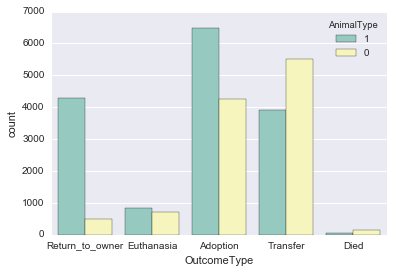

In [11]:
sns.countplot(data=data, x='OutcomeType',hue='AnimalType', palette="Set3")

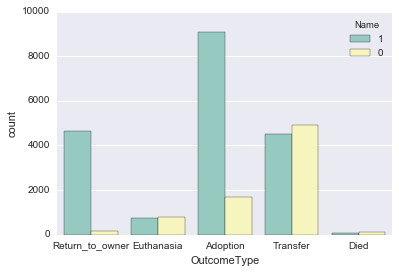

In [12]:
sns.countplot(data=data, x='OutcomeType',hue='Name', palette="Set3")

This graph shows how important is for an animal to have an ID tag. The animals with unknown names have almost no chance to return to owners and have less chance to be adopted.

Now let's convert age into a float:

In [13]:
def age_as_float(x):
    x = str(x)
    x_list = x.split(" ")
    if len(x_list)==2:
        if x_list[1] =='year': return 1.0
        elif x_list[1] =='years': return float(x_list[0])
        elif x_list[1] =='month': return float(x_list[0])/12
        elif x_list[1] =='months': return float(x_list[0])/12
        elif x_list[1] =='week': return float(x_list[0])
        elif x_list[1] =='weeks': return float(x_list[0])/54
        elif x_list[1] =='days': return float(x_list[0])/365
        else: return 0
    else:return 0


data['AgeuponOutcome'] = data.AgeuponOutcome.apply(age_as_float)
#now we have 0 age for the animals with undefined age. Let's replace 0 by mean age:
data.loc[data['AgeuponOutcome']== 0, "AgeuponOutcome"] = data['AgeuponOutcome'].median()
data.head()

Name      OutcomeType AnimalType SexuponOutcome  AgeuponOutcome  \
0    1  Return_to_owner          1  Neutered Male        1.000000   
1    1       Euthanasia          0  Spayed Female        1.000000   
2    1         Adoption          1  Neutered Male        2.000000   
3    0         Transfer          0    Intact Male        0.055556   
4    0         Transfer          1  Neutered Male        2.000000   

                         Breed        Color  
0        Shetland Sheepdog Mix  Brown/White  
1       Domestic Shorthair Mix  Cream Tabby  
2                 Pit Bull Mix   Blue/White  
3       Domestic Shorthair Mix   Blue Cream  
4  Lhasa Apso/Miniature Poodle          Tan

Now let's think about SexuponOutcome and Breed columns.

In [14]:
len(data["Breed"].unique())

1380

Very few animals have a pure breed (for example'Cairn Terrier') and a lot of animals are mix. Let's replace all variations of mix by "Mix"

In [15]:
def mix(x):
    x = str(x)
    if x.find('Mix')> -1 or x.find('mix')> -1 or x.find("/") > -1: return "Mix"
    else: return x
data['Breed'] = data.Breed.apply(mix)
print(len(data["Breed"].unique()))

140


140 breeds of dogs and cats make up too many classes. A possible class division can be made by calling Mix breeds as 1 and others 0

In [16]:
#let's Mis breed will be 1 and pure breeds will be 0
data.loc[data["Breed"]== "Mix", "Breed"] = 1
data.loc[data["Breed"]!= 1, "Breed"] = 0
print(data["Breed"].unique())

[1 0]


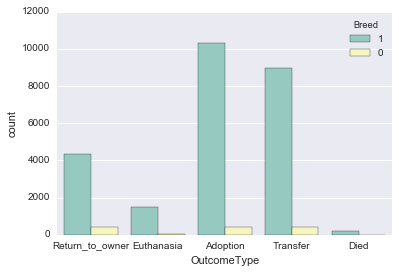

In [17]:
sns.countplot(data=data, x='OutcomeType',hue='Breed', palette="Set3")

It looks like the proportion of pure and mix breeds are about the same for all categories of outcome.

Now we create dummy variables so as to utilize all the feature pre-processing we have performed so far:

In [18]:
def create_dummies(var):
    var_unique = var.unique()
    var_unique.sort()
    dummy = pd.DataFrame()
    for val in var_unique:
    #for val in var_unique[:-1]:
        # which columns are equal to our unique value
        d = var == val
        # make a new column with a dummy variable
        dummy[var.name + "_" + str(val)] = d.astype(int)
    return(dummy)

sex_dummies = create_dummies(data["SexuponOutcome"])
data = pd.concat([data, sex_dummies], axis=1)
del data["SexuponOutcome"]
data.head()

Name      OutcomeType AnimalType  AgeuponOutcome Breed        Color  \
0    1  Return_to_owner          1        1.000000     1  Brown/White   
1    1       Euthanasia          0        1.000000     1  Cream Tabby   
2    1         Adoption          1        2.000000     1   Blue/White   
3    0         Transfer          0        0.055556     1   Blue Cream   
4    0         Transfer          1        2.000000     1          Tan   

   SexuponOutcome_Intact Female  SexuponOutcome_Intact Male  \
0                             0                           0   
1                             0                           0   
2                             0                           0   
3                             0                           1   
4                             0                           0   

   SexuponOutcome_Neutered Male  SexuponOutcome_Spayed Female  \
0                             1                             0   
1                             0                             1   
2                             1                             0   
3                             0                             0   
4                             1                             0   

   SexuponOutcome_Unknown  
0                       0  
1                       0  
2                       0  
3                       0  
4                       0

Now we can try multi class logistic regression to predict outcomes. Remember that the intact and neutered/spayed Sexuponoutcomes are complementary. 

In this competition, we are going to use the log-loss metric. This error metric is used where we have to predict that something is true or false with a probability (likelihood) ranging from definitely true (1) to equally true (0.5) to definitely false(0).

The use of log on the error provides extreme punishments for being both confident and wrong. In the worst possible case, a single prediction that something is definitely true (1) when it is actually false will add infinite to your error score and make every other entry pointless. 

In [19]:
features = ['Name','AnimalType', 'AgeuponOutcome', 'Breed', 'SexuponOutcome_Neutered Male', 'SexuponOutcome_Spayed Female', \
            'SexuponOutcome_Unknown']

In [20]:
"""
import numpy as np
# shuffle data
shuffled_rows = np.random.permutation(data.index)

# Select 75% of the dataset to be training data
highest_train_row = int(data.shape[0] * .75)
train = data.loc[shuffled_rows[:highest_train_row], :]

# Select 25% of the dataset to be test data
my_test = data.loc[shuffled_rows[highest_train_row:], :]
"""


from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[features], data["OutcomeType"], stratify=data["OutcomeType"], random_state=100)

X_train.head()

Name AnimalType  AgeuponOutcome Breed  SexuponOutcome_Neutered Male  \
23333    0          1        2.000000     1                             0   
813      0          0        0.037037     1                             0   
4633     1          1        0.250000     1                             1   
24713    1          1        2.000000     1                             0   
9018     0          0        0.166667     1                             0   

       SexuponOutcome_Spayed Female  SexuponOutcome_Unknown  
23333                             0                       0  
813                               0                       0  
4633                              0                       0  
24713                             1                       0  
9018                              1                       0

In [21]:
# for converting soft predictions into hard one : not to be used as log-loss is the metric.
def normalizer(mat):
    a = np.array(mat)
    b = np.zeros_like(a)
    b[np.arange(len(a)), a.argmax(1)] = True
    return b

In [22]:
alg = LogisticRegression(random_state=1)
alg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [23]:
probs = alg.predict_proba(X_test)
#probs=normalizer(probs)
#print probs

In [24]:
score = log_loss(y_test, probs)
print(score)

0.923519951571


Now let's create a prediction for test.csv and submit it for Kagle competition. For that, we need to perform the similar preprocessing again on the test set. 

In [25]:
test = pd.read_csv("test.csv")
print test.shape
test['AnimalType'] =test['AnimalType'].fillna("Dog")
test['Breed'] =test['Breed'].fillna("Mix")
del test['Color']
test['SexuponOutcome'] =test['SexuponOutcome'].fillna("Neutered Male")
#del test["ID"]
del test["DateTime"]
test['Name'] =test['Name'].fillna(0)
test.loc[test['Name'] != 0, "Name"] = 1
test.loc[test["AnimalType"]== "Dog", "AnimalType"] = 1
test.loc[test["AnimalType"]!= 1, "AnimalType"] = 0
test['AgeuponOutcome'] = test.AgeuponOutcome.apply(age_as_float)
test.loc[test['AgeuponOutcome']== 0, "AgeuponOutcome"] = test['AgeuponOutcome'].median()
test.loc[test["Breed"]== "Mix", "Breed"] = 1
test.loc[test["Breed"]!= 1, "Breed"] = 0
sex_dummies = create_dummies(test["SexuponOutcome"])
test = pd.concat([test, sex_dummies], axis=1)
del test["SexuponOutcome"]
test.head()

(11456, 8)


ID Name AnimalType  AgeuponOutcome Breed  SexuponOutcome_Intact Female  \
0   1    1          1        0.833333     0                             1   
1   2    1          1        2.000000     0                             0   
2   3    1          0        1.000000     0                             0   
3   4    1          1        0.333333     0                             0   
4   5    1          1        2.000000     0                             0   

   SexuponOutcome_Intact Male  SexuponOutcome_Neutered Male  \
0                           0                             0   
1                           0                             0   
2                           0                             1   
3                           1                             0   
4                           0                             1   

   SexuponOutcome_Spayed Female  SexuponOutcome_Unknown  
0                             0                       0  
1                             1                       0  
2                             0                       0  
3                             0                       0  
4                             0                       0

In [26]:
result = pd.DataFrame(alg.predict_proba(test[features]), index=test.index, columns=alg.classes_)
result.head()

Adoption      Died  Euthanasia  Return_to_owner  Transfer
0  0.040064  0.019254    0.044120         0.299753  0.596809
1  0.520073  0.002874    0.010949         0.305080  0.161024
2  0.647404  0.006971    0.009877         0.076055  0.259693
3  0.045452  0.019617    0.040281         0.286120  0.608531
4  0.474885  0.003112    0.014714         0.333300  0.173989

In [27]:
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission.head()

ID  Adoption  Died  Euthanasia  Return_to_owner  Transfer
0   1         1     0           0                0         0
1   2         1     0           0                0         0
2   3         1     0           0                0         0
3   4         1     0           0                0         0
4   5         1     0           0                0         0

In [28]:
# for converting soft predictions into hard one : not to be used as log-loss is the metric.
def final_result(result):
    a = np.array(result)
    b = np.zeros_like(a)
    b[np.arange(len(a)), a.argmax(1)] = True
    final=pd.DataFrame(b,columns=["Adoption","Died","Euthanasia","Return_to_owner","Transfer"])
    return final
#final=final_result(result)

In [29]:
mid = sample_submission['ID']
#final.insert(0, 'ID', mid)
#final.head()
result.insert(0, 'ID', mid)
result.head()

ID  Adoption      Died  Euthanasia  Return_to_owner  Transfer
0   1  0.040064  0.019254    0.044120         0.299753  0.596809
1   2  0.520073  0.002874    0.010949         0.305080  0.161024
2   3  0.647404  0.006971    0.009877         0.076055  0.259693
3   4  0.045452  0.019617    0.040281         0.286120  0.608531
4   5  0.474885  0.003112    0.014714         0.333300  0.173989

In [30]:
result.to_csv("gaurav3.csv", index=False)

0.92673 : score after first submission. The scores of other participants are between 0.45 and 29.00. 

In [31]:
alg2 = RandomForestClassifier()
alg2.fit(X_train, y_train)
probs = alg2.predict_proba(X_test)
score = log_loss(y_test, probs)
print(score)

1.19138880064


In [32]:
alg3 = KNeighborsClassifier(5)
alg3.fit(X_train, y_train)
probs = alg3.predict_proba(X_test)
score = log_loss(y_test, probs)
print(score)

4.65092215777


Too bad

In [33]:
alg4 =AdaBoostClassifier()
alg4.fit(X_train, y_train)
probs = alg4.predict_proba(X_test)
score = log_loss(y_test, probs)
print(score)

1.5534958957


In [34]:
alg5 = GaussianNB()
alg5.fit(X_train, y_train)
probs = alg5.predict_proba(X_test)
score = log_loss(y_test, probs)
print(score)

3.97202103054


In [35]:
alg6 = DecisionTreeClassifier()
alg6.fit(X_train, y_train)
probs = alg6.predict_proba(X_test)
score = log_loss(y_test, probs)
print(score)

1.34763768116


Let's find out the feature importances...

[ 0.17710915  0.09404226  0.31454183  0.00811189  0.194596    0.19093666
  0.02066221]
[2 4 5 0 1 6 3]
['AgeuponOutcome', 'SexuponOutcome_Neutered Male', 'SexuponOutcome_Spayed Female', 'Name', 'AnimalType', 'SexuponOutcome_Unknown', 'Breed']
Feature ranking:
1. AgeuponOutcome (0.314542)
2. SexuponOutcome_Neutered Male (0.194596)
3. SexuponOutcome_Spayed Female (0.190937)
4. Name (0.177109)
5. AnimalType (0.094042)
6. SexuponOutcome_Unknown (0.020662)
7. Breed (0.008112)


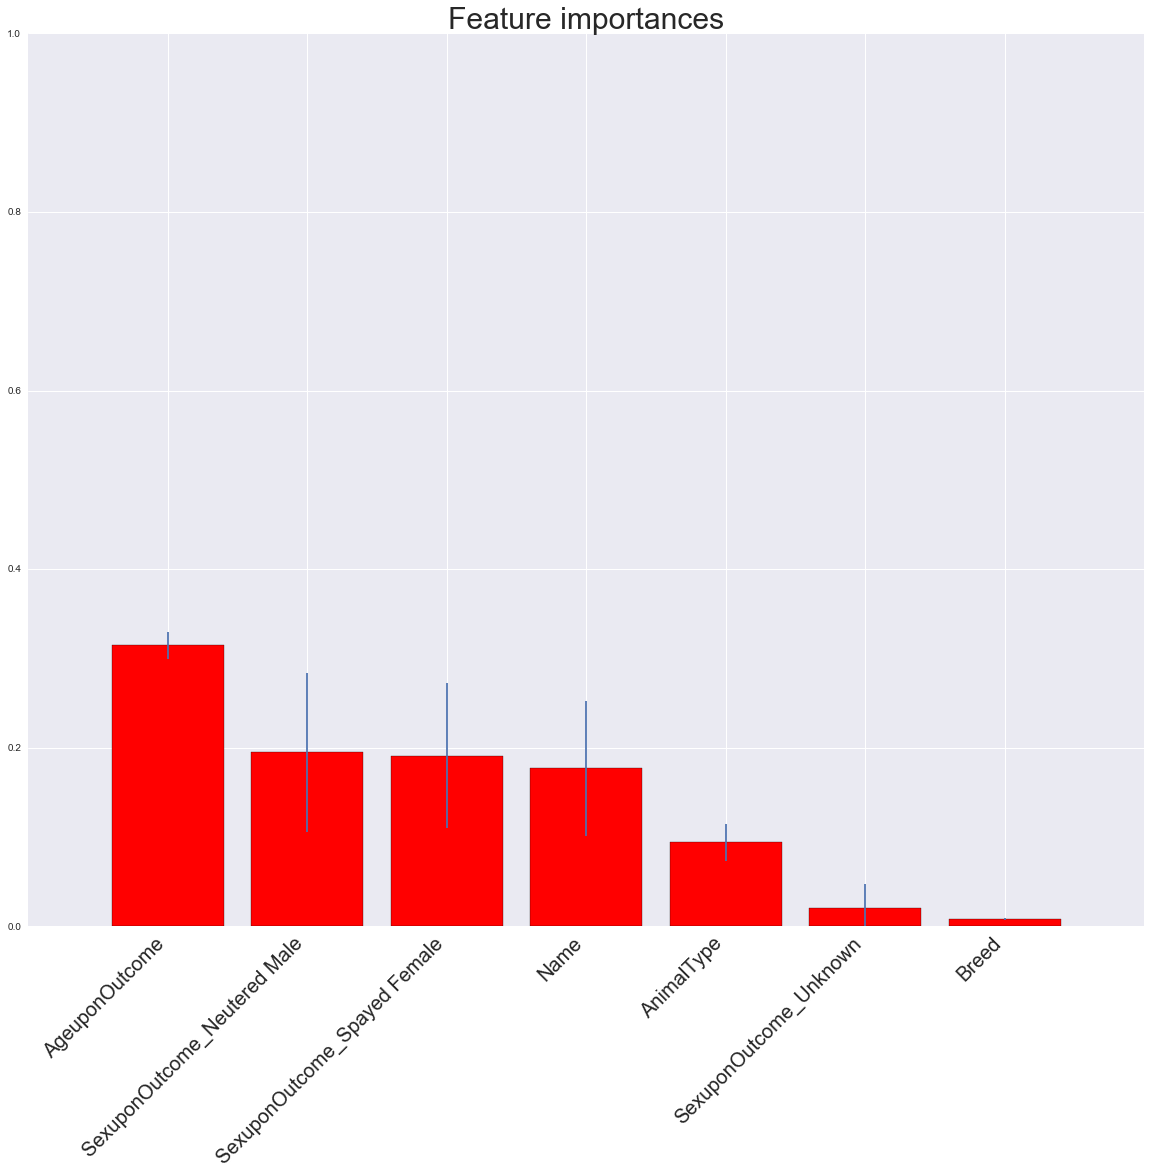

In [53]:
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
feature_names=list(X_train[features].columns.values)
# Build a classification task using 3 informative features
X, y = X_train, y_train

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
print importances
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
print indices
sorted_features=[]
for k in indices:
    sorted_features.append(feature_names[k])
print sorted_features

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))


# Plot the feature importances of the forest
plt.figure(num=None, figsize=(20, 16), dpi=80, facecolor='w', edgecolor='k')
N = len(sorted_features)  # number of groups
ind = np.arange(N)  # group positions
width = 0.1  # bar width

#fig, ax = plt.subplots()


plt.title("Feature importances", fontsize =30)
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")

plt.xticks(range(X.shape[1]),sorted_features,rotation=45,ha='right',fontsize = 20)
#plt.set_xticklabels(sorted_features,
                   #rotation=40,
                   #ha='right')
plt.xlim([-1, X.shape[1]])
plt.ylim([0, 1])
plt.show()

CalibratedClassifierCV is something we didn't encounter in the Nanodegree program. As per sklearn's page on Calibrated Classification:

*When performing classification you often want to predict not only the class label, but also the associated probability. This probability gives you some kind of confidence on the prediction. However, not all classifiers provide well-calibrated probabilities, some being over-confident while others being under-confident. Thus, a separate calibration of predicted probabilities is often desirable as a postprocessing.*

This does sound like what we should be using.

In [37]:
alg7 = CalibratedClassifierCV()
alg7.fit(X_train, y_train)
probs = alg7.predict_proba(X_test)
score = log_loss(y_test, probs)
print(score)

0.92816163259


The result is similar to that of Logistic Regression. Can be submitted!

In [38]:
result = pd.DataFrame(alg7.predict_proba(test[features]), index=test.index, columns=alg7.classes_)
result.insert(0, 'ID', mid)
result.head()

ID  Adoption      Died  Euthanasia  Return_to_owner  Transfer
0   1  0.044069  0.014229    0.037501         0.288958  0.615243
1   2  0.521059  0.002652    0.012072         0.299013  0.165204
2   3  0.653734  0.004980    0.009653         0.086364  0.245270
3   4  0.051154  0.014503    0.034065         0.272088  0.628191
4   5  0.470466  0.002816    0.014872         0.334005  0.177841

In [39]:
result.to_csv("gaurav4.csv", index=False)

I got 0.93516 after this submission.

So far, we have tried some of the great classification methods and some of them perform as well as others. At this stage, I would like to utilize the Voting Classifier functionality of ensemble methods of the sklearn. As per sklearn's page on Voting Classifier:

*The idea behind the voting classifier implementation is to combine conceptually different machine learning classifiers and use a majority vote or the average predicted probabilities (soft vote) to predict the class labels. Such a classifier can be useful for a set of equally well performing model in order to balance out their individual weaknesses*

In [40]:
# Voting Classifier over Calibrated Classifier and Logistic Regression
eclf1 = VotingClassifier(estimators=[('lr', alg), ('calC', alg7)], voting='soft')
eclf1.fit(X_train, y_train)
probs = eclf1.predict_proba(X_test)
score = log_loss(y_test, probs)
print(score)

0.924830450516


In [41]:
# Voting Classifier over Calibrated Classifier, Random Forest Classifier and Logistic Regression
eclf2 = VotingClassifier(estimators=[('lr', alg), ('calC', alg7), ("ranFor", alg2)], voting='soft')
eclf2.fit(X_train, y_train)
probs = eclf2.predict_proba(X_test)
score = log_loss(y_test, probs)
print(score)

0.883729139224


In [42]:
# Voting Classifier over Calibrated Classifier, Random Forest Classifier, Decision Tree Classifier and Logistic Regression
eclf3 = VotingClassifier(estimators=[('lr', alg), ('calC', alg7), ("ranFor", alg2), ("DT", alg6)], voting='soft')
eclf3.fit(X_train, y_train)
probs = eclf3.predict_proba(X_test)
score = log_loss(y_test, probs)
print(score)

0.871235004089


In [43]:
# Voting Classifier over Calibrated Classifier, Random Forest Classifier, Decision Tree Classifier, 
# AdaBoost Classifier and Logistic Regression
eclf4 = VotingClassifier(estimators=[('lr', alg), ('calC', alg7), ("ranFor", alg2), ("DT", alg6), ("Ada", alg4)], voting='soft')
eclf4.fit(X_train, y_train)
probs = eclf4.predict_proba(X_test)
score = log_loss(y_test, probs)
print(score)

0.935965897368


eclf3 looks promising can be submitted.

In [44]:
result = pd.DataFrame(eclf3.predict_proba(test[features]), index=test.index, columns=eclf3.classes_)
result.insert(0, 'ID', mid)
result.to_csv("gaurav5.csv", index=False)

0.93881 - the submission score

In [45]:
result = pd.DataFrame(eclf2.predict_proba(test[features]), index=test.index, columns=eclf2.classes_)
result.insert(0, 'ID', mid)
result.to_csv("gaurav6.csv", index=False)

0.92192 - best submission score so far - selected as the final model.

In [46]:
result = pd.DataFrame(eclf1.predict_proba(test[features]), index=test.index, columns=eclf1.classes_)
result.insert(0, 'ID', mid)
result.to_csv("gaurav7.csv", index=False)

submission score for eclf1 : 0.93871

Let us visualize the working of voting classifier:

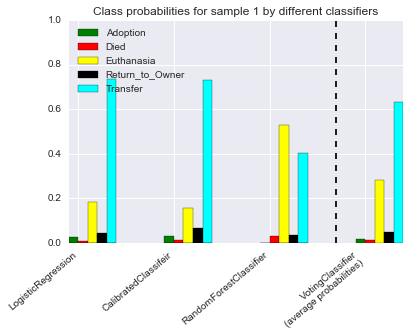

In [47]:
# Voting Classifier over Calibrated Classifier, Random Forest Classifier and Logistic Regression
eclf2 = VotingClassifier(estimators=[('lr', alg), ('calC', alg7), ("ranFor", alg2)], voting='soft')
eclf2.fit(X_train, y_train)
probs = eclf2.predict_proba(X_test)

# predict class probabilities for all 3 classifiers for the final model
probas = [c.fit(X, y).predict_proba(X) for c in (alg, alg7, alg2, eclf2)]

# get class probabilities for the first sample in the dataset
class1_1 = [pr[0, 0] for pr in probas]
class2_1 = [pr[0, 1] for pr in probas]
class3_1 = [pr[0, 2] for pr in probas]
class4_1 = [pr[0, 3] for pr in probas]
class5_1 = [pr[0, 4] for pr in probas]


# plotting

N = 4  # number of groups
ind = np.arange(N)  # group positions
width = 0.1  # bar width

fig, ax = plt.subplots()

# bars for classifier 1-3
p1 = ax.bar(ind, np.hstack(([class1_1[:-1], [0]])), width, color='green')
p2 = ax.bar(ind + width, np.hstack(([class2_1[:-1], [0]])), width, color='red')
p3 = ax.bar(ind + 2*width, np.hstack(([class3_1[:-1], [0]])), width, color='yellow')
p4 = ax.bar(ind + 3*width, np.hstack(([class4_1[:-1], [0]])), width, color='black')
p5 = ax.bar(ind + 4*width, np.hstack(([class5_1[:-1], [0]])), width, color='cyan')



# bars for VotingClassifier
p6 = ax.bar(ind, [0, 0, 0, class1_1[-1]], width, color='green')
p7 = ax.bar(ind + width, [0, 0, 0, class2_1[-1]], width, color='red')
p8 = ax.bar(ind + 2*width, [0, 0, 0, class3_1[-1]], width, color='yellow')
p9 = ax.bar(ind + 3*width, [0, 0, 0, class4_1[-1]], width, color='black')
p10 = ax.bar(ind + 4*width, [0, 0, 0, class5_1[-1]], width, color='cyan')

# plot annotations
plt.axvline(2.8, color='k', linestyle='dashed')
ax.set_xticks(ind + width)
ax.set_xticklabels(['LogisticRegression',
                    'CalibratedClassifeir',
                    'RandomForestClassifier',
                    'VotingClassifier\n(average probabilities)'],
                   rotation=40,
                   ha='right')
plt.ylim([0, 1])
plt.title('Class probabilities for sample 1 by different classifiers')
plt.legend([p1[0], p2[0], p3[0], p4[0], p5[0]], ['Adoption', 'Died', 'Euthanasia','Return_to_Owner', 'Transfer'], loc='upper left')
plt.show()

The dataset is huge. Using SVM might not be a great idea!!

## Conclusion

### Work Done:

1. Pre-processed data, remove missing values, and created dummy variables for better feature-set.
2. Used several classifiers :Calibrated Classifier, Random Forest Classifier, Decision Tree Classifier, AdaBoost Classifier and Logistic Regression.
3. Used VotingClassifier from sklearn to obtain better results.

### Interesting Observations

1. Neutered Male and Spayed Female have a great chance to be adopted, and a pretty decent chance to be returned to the owner. However, it appears harder to find new family for Intact Male and Intact Female! 
2. We have shown how important it is for an animal to have an ID tag. The animals with unknown names have almost no chance to return to owners and have less chance to be adopted.

### What else can be done?

1. We can find out which breeds are considered dangerous which will be more likely to be euthanized; similarly, some breeds, and animal colors are very popular and very likely to be adopted. However, more information from several other definite sources have to be obtained to perform this analysis.
2. DateTime variable might be interesting. Maybe Euthanizations are performed early morning, while adoptions happen more on weekends. However, this will require much more data wrangling and less of new machine learning concepts. 